<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Deep Learning in PyTorch

In [2]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
git_user = "AIPI540" # Enter user or organization name
git_email = "jon.reifschneider@gmail.com" # Enter your email
repo_name = "class_demos" # Enter repo name
# Use the below if repo is private, or is public and you want to push to it
# Otherwise comment next two lines out
#git_token = input("enter git token") # Enter your github token 
#git_path = f"https://{git_token}@github.com/{git_user}/{repo_name}.git"
# Use the below instead if repo is public and you do not need to push to it
git_path = 'https://github.com/AIPI540/class_demos.git' #Enter repo url
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'nn_basics'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

# Mount Google drive to access files there
# from google.colab import drive
# drive.mount('/content/gdrive')
# # Path to files in Google Drive
# path_to_gdrive_files = '../../gdrive/MyDrive/AIPI540/class_demos/computer_vision'
# # Display contents
# print('Contents of gdrive directory:')
# print(os.listdir(path_to_gdrive_files))

rm: ./sample_data: No such file or directory
Cloning into 'class_demos'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 194 (delta 103), reused 117 (delta 43), pack-reused 0
Receiving objects: 100% (194/194), 59.28 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/Users/jjr10/Google Drive/AIPI540/class_demos/nn_basics/class_demos/nn_basics
iris.csv                pytorch_nn_intro.ipynb  saved_models/


In [18]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Regression
For regression we use `nn.MSELoss()` as our loss function.

In [19]:
# Read data in and clean up
crimes = pd.read_csv('communities.csv',na_values=['?'])
crimes.fillna(crimes.mean(),inplace=True)
crimes.drop(columns=['state','country','community','communityname','fold'],inplace=True)

X = crimes.iloc[:,:-1]
y = crimes.iloc[:,-1]

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=0.2)

### Step 1: Set up dataloaders for our data
The first step is to set up the dataloaders to feed our data into the model.  We first create a `TensorDataset` for our training data and our test data.  Then we create `DataLoaders` for the training and test data which allow us to iteratively feed the data into our model in batches (called "mini-batches") of a size that we can specify.

In [20]:
def prep_dataloaders(X_train,y_train,X_test,y_test,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train).astype('float32')), 
                            torch.from_numpy(np.array(y_train).astype('float32')).view(-1,1))
    testset = TensorDataset(torch.from_numpy(np.array(X_test).astype('float32')), 
                            torch.from_numpy(np.array(y_test).astype('float32')).view(-1,1))

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

batchsize = 32
trainloader,testloader = prep_dataloaders(X_train,y_train,X_test,y_test,batchsize)

### Step 2: Define our neural network architecture
Next, we will define a model, feed-forward neural network for this chapter..
For simplicity, we will use 3-layer, 2 hidden layers and 1 hidden-to-output layer, feed-forward net. Each layer is a fully-connected layer where the module `torch.nn.Linear` is the implementation of it. Also, we will apply ReLU activation for each layer.

Basically, we are required to define a member method of `forward(self, x)` when we define a class for any customized network. It represents a forward pass of a computational graph and a backward pass (back-propagation) with automatic differentiation will be performed later based on this forward definition.

In [21]:
class RegressionNet(nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super().__init__()
        self.hidden1 = nn.Linear(122, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

# Instantiate our neural network
net = RegressionNet(n_hidden1=50, n_hidden2=5)

### Step 3: Define a cost / loss function and optimizer
We will use Mean Squared Error as our loss function, which is usually named `criterion` in PyTorch.  For our optimizer we will use stochastic gradient descent (SGD).

When we create an optimizer in PyTorch, we need to pass in the parameters that we want to optimize (train), which are our weights. We can retrieve all trainable parameters of the model by calling `model.parameters()`.

In [22]:
# Define the cost / loss function
criterion = nn.MSELoss()
# Define the method of updating the weights each iteration
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

In [23]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    cost = []
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

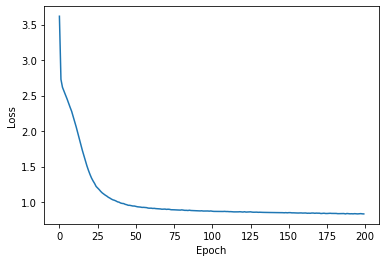

In [24]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of iterations (epochs) to train
n_iter = 200

cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Step 5: Test the model on the test set

In [25]:
def test_model(model,test_loader):
    # Turn autograd off
    with torch.no_grad(): 
        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()
        test_preds = []
        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model.forward(inputs)
            test_preds.extend(outputs.cpu().squeeze().tolist())

    return test_preds

testpreds = test_model(net,testloader)
test_mse = 1/len(y_test)*np.sum((np.array(testpreds)-np.array(y_test))**2)
print('The test set MSE of your model is {:.4f}'.format(test_mse))

The test set MSE of your model is 0.0204


# Binary classification
For binary classification, we can use a sigmoid activation function on the output layer to get our predictions in the range (0,1) and then use PyTorch's `BCELoss()` loss function (equivalent to Negative Log Likelihood)

In [26]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 1: Set up dataloaders for our data
The first step is to set up the dataloaders to feed our data into the model.  We first create a `TensorDataset` for our training data and our test data.  Then we create `DataLoaders` for the training and test data which allow us to iteratively feed the data into our model in batches (called "mini-batches") of a size that we can specify.

In [27]:
# Set random seeds
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(y_train).float())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), 
                        torch.from_numpy(y_test).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

### Step 2: Define our neural network architecture
Next, we will define a model, feed-forward neural network for this chapter..
For simplicity, we will use 3-layer, 2 hidden layers and 1 hidden-to-output layer, feed-forward net. Each layer is a fully-connected layer where the module `torch.nn.Linear` is the implementation of it. Also, we will apply ReLU activation for each layer.

Basically, we are required to define a member method of `forward(self, x)` when we define a class for any customized network. It represents a forward pass of a computational graph and a backward pass (back-propagation) with automatic differentiation will be performed later based on this forward definition.

In [28]:
class FeedForwardNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [29]:
# Instantiate our neural network
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=50, n_hidden2=20, n_output=1)

Alternatively, PyTorch gives us an easy way to define a model layer by layer using `nn.Sequential()` rather than creating a model class as we did above.  Here we define the same model as above much more simply:

In [30]:
# Build a feed-forward network
n_input = X_train_scaled.shape[1]
n_hidden1 = 50
n_hidden2 = 20
n_output = 1

net = nn.Sequential(nn.Linear(n_input, n_hidden1),  # hidden layer 1
                      nn.ReLU(), # hidden layer 1 activation
                      nn.Linear(n_hidden1, n_hidden2), # hidden layer 2
                      nn.ReLU(), # hidden layer 2 activation
                      nn.Linear(n_hidden2, n_output), # output layer
                      nn.Sigmoid()) # use sigmoid as output activation

### Step 3: Define a cost / loss function and optimizer
We will use Binary Cross Entropy as our loss function, which is usually named `criterion` in PyTorch.  For our optimizer we will use stochastic gradient descent (SGD).

When we create an optimizer in PyTorch, we need to pass in the parameters that we want to optimize (train), which are our weights. We can retrieve all trainable parameters of the model by calling `model.parameters()`.

In [31]:
import torch.optim as optim

# Define the cost / loss function
cost_fn = nn.BCELoss()

# Define the method of updating the weights each iteration (e.g. gradient descent)
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 4: Train the model
To train our model, we perform the following four steps in a loop, using one input mini-batch at a time:  
    1) Make a forward pass through the network to calculate the network output  
    2) Use the network output to calculate the cost/loss  
    3) Calculate the gradient of the cost/loss with respect to the weights by performing a backward pass through the network with loss.backward()  
    4) Update the weights by taking a step with the optimizer

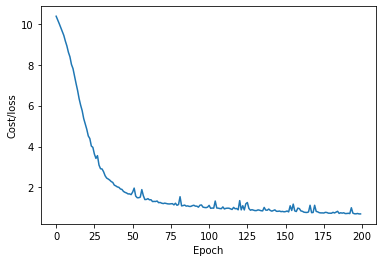

In [32]:
num_iter = 200
cost = []

net = net.to(device)
net.train() # Set the model to training mode

for epoch in range(num_iter):

    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        
        # Get the inputs X and labels y for the minibatch
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients of the weights each iteration
        optimizer.zero_grad()

        # Calculate the predictions and the cost/loss
        outputs = net(inputs).view(-1) # Convert outputs to 1D array instead of 2D to match labels
        loss = cost_fn(outputs, labels)
        
        # Use autograd to calculate the gradient of the cost with respect to each weight
        loss.backward()
        
        # Use the optimizer to do the weights update
        optimizer.step()

        # Store the cost/loss
        running_loss += loss.item()
        
    cost.append(running_loss)
        
plt.plot(cost)
plt.xlabel('Epoch')
plt.ylabel('Cost/loss')
plt.show()

### Step 5: Test the model on the test set

In [33]:
# Set the model to evaluation mode
net.eval()
with torch.no_grad():
    # Set up lists to store true and predicted values
    y_true = y_test.tolist
    test_preds = []

    # Calculate the predictions on the test set and add to list
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net.forward(inputs)
        test_preds.extend(outputs.cpu().squeeze().tolist())

    # Convert the predictions to discrete and calculate the accuracy
    test_preds = np.round(test_preds)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.965


# Multiclass classification
For a multi-class problem we use a softmax as the activation function to convert the outputs to probabilities, rather than sigmoid as we did in binary classification.  We also use cross-entropy (`nn.CrossEntropyLoss()`) as the loss function rather than negative log likelihood (`BCELoss()`) as we did previously.  Since PyTorch's `nn.CrossEntropyLoss()` applies a softmax before calculating the loss, we do not need to use a softmax on the output from the output layer, as we did with a sigmoid in our binary classification model.

In [34]:
# Load the iris data
iris = pd.read_csv('iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [35]:
# Separate into X and y
# Convert string species values in y to numerical codes for modeling
X = iris.drop('species',axis=1)
y = iris['species'].astype('category').cat.codes

In [36]:
# Split data into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print("Shape of X_train, y_train:",X_train.shape,y_train.shape)
print("Shape of X_test, y_test:",X_test.shape,y_test.shape)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y_train and y_test to arrays so all inputs are in NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

Shape of X_train, y_train: (120, 4) (120,)
Shape of X_test, y_test: (30, 4) (30,)


In [37]:
# Convert training and test data to TensorDatasets
# When we do multiclass classification, PyTorch expects that labels are type LongTensor and inputs are FloatTensor
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), 
                         torch.from_numpy(y_train).long())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), 
                        torch.from_numpy(y_test).long())

batchsize = 32
# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

In [38]:
class Multiclass_Net(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_hidden3, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3)
        self.out = nn.Linear(n_hidden3, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x
    
# Instantiate our neural network
# n_input=4 since we have 4 features
# n_output=3 since we have 3 classes
net = Multiclass_Net(n_input=4, n_hidden1=100, n_hidden2=50, n_hidden3=10, n_output=3)

In [39]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    
    model = model.to(device)
    model.train() # Set the model to training mode
    
    cost = []
    
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

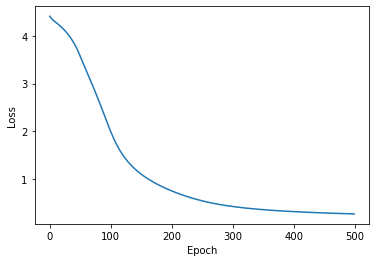

In [40]:
# Define the cost / loss function
criterion = nn.CrossEntropyLoss()
# Define the method of updating the weights each iteration
optimizer = optim.SGD(net.parameters(), lr=0.01)
# Number of iterations (epochs) to train
n_iter = 500
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train model
cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

# Plot the cost over training
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [41]:
def test_model(model,test_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = net.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_acc = np.sum(test_preds==y_test)/len(y_test)
    
    return test_acc

In [42]:
# Test model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = test_model(net,testloader,device)
print('Test set accuracy is {:.3f}'.format(acc))

Test set accuracy is 1.000


### Saving models
To save PyTorch models for later use, we have two options:  
1) We can save the `state_dict` which contains all the learned parameters of the model (the weights and biases) but not the architecture itself.  To use it, we instantiate a new model of the desired architecture and then load the saved `state_dict` to assign values to all the parameters in the model  
2) We can alternatively save the entire model including the architecture, and then load it up and use it for prediction

In [ ]:
# OPTION 1: Save the state dictionary of the model

model_dir = 'saved_models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(net.state_dict(), model_dir+filename)

In [ ]:
# Initialize new model and load state dict previously saved into it
model = Multiclass_Net(n_input=4, n_hidden1=100, n_hidden2=50, n_hidden3=10, n_output=3)
model.load_state_dict(torch.load(model_dir+filename))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
acc = test_model(model,testloader,device)
print()
print('Test set accuracy is {:.3f}'.format(acc))

In [ ]:
# OPTION 2: Save the entire model

model_dir = 'saved_models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'fullmodel.pt'

# Save the entire model
torch.save(net, model_dir+filename)

In [ ]:
# Load model
model2 = torch.load(model_dir+filename)

# Test loaded model
acc = test_model(model2,testloader,device)
print('Test set accuracy is {:.3f}'.format(acc))

In [ ]:
# Run this cell only if working in Colab and you want to push new/changed files to GitHub
# Note: you will need to manually save your current notebook to GitHub after running this cell

# !git config --global user.email "{git_email}"
# !git config --global user.name "{git_user}"
# !git add --all #List files here that you have added or changed, other than this notebook
# !git commit -m "updated from colab"
# !git push